#### Data Preprocessing

In [2]:
from boxsers.preprocessing import savgol_smoothing, cosmic_filter

def preprocessing_method(x):
    # 1) Applies a median filter to remove cosmic rays from the spectrum(s).
    x = cosmic_filter(x, ks=3)
    # 2) Smoothes the spectra
    x = savgol_smoothing(x, 7, p=3, degree=0)
    return x

#### Loading Dataset

In [3]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import json

##### Train Dataset

In [4]:
with open("./data/Melanoma/train_data.json", 'r') as f:
    train_data = json.load(f)

temp_data = []
temp_labels = []

for label, sub_data in train_data.items():
    for kind, array_data in sub_data.items():
        temp_data.extend(array_data)
        temp_labels.extend([label] * len(array_data))

train_data = np.array(temp_data)
train_data = preprocessing_method(train_data)
train_label = np.array(temp_labels)
label_encoder = LabelEncoder()
train_label = label_encoder.fit_transform(train_label)

##### Test Dataset

In [5]:
with open("./data/Melanoma/test_data.json", 'r') as f:
    test_data = json.load(f)

temp_data = []
temp_labels = []

for label, sub_data in test_data.items():
    for kind, array_data in sub_data.items():
        temp_data.extend(array_data)
        temp_labels.extend([label] * len(array_data))

test_data = np.array(temp_data)
test_data = preprocessing_method(test_data)
test_labels = np.array(temp_labels)
test_labels = label_encoder.transform(test_labels)

#### Model Setting

In [7]:
from model.Variant_LeNet_without_linear import Variant_LeNet_without_linear
from tqdm import tqdm
import torch
import pandas as pd
import torch.nn as nn
from torch.autograd import Variable
from functools import partial
from deep_SLDA import slda_loss, SLDA
from imblearn.metrics import specificity_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import torch.optim as optim
import seaborn as sns
from sklearn.metrics import confusion_matrix
import math
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    auc,
    roc_curve,
)
from plot import plot_melanoma_ROC_curve, plot_melanoma_heatmap, plot_loss_metrics, plot_metrics

n_classes = 12
batch_size = 1000

train_avg_accuracy = []
val_avg_accuracy = []
avg_accuracy = []
avg_roc = []
C = np.zeros((12, 12))

In [8]:
class Solver:
    def __init__(
        self,
        dataloaders,
        model,
        model_path,
        device,
        n_classes,
    ):
        self.dataloaders = dataloaders
        self.device = device
        self.net = model
        self.net = self.net.to(self.device)

        self.criterion = partial(
            slda_loss,
            n_classes=n_classes,
        )

        self.optimizer = optim.Adam(self.net.parameters(), lr=1e-4, betas=(0.5, 0.999))
        self.model_path = model_path
        self.n_classes = n_classes
        self.slda_layer = SLDA(self.n_classes)

    def iterate(self, epoch, phase, scheduler=None):
        if phase == "train":
            self.net.train()
        else:
            self.net.eval()

        dataloader = self.dataloaders[phase]
        total_loss = 0
        correct = 0
        total = 0
        loss_total = 0

        if phase == "train":
            self.optimizer.zero_grad()

        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs = Variable(inputs).to(self.device)
            targets= Variable(targets).to(self.device)

            feas = self.net(inputs)

            if phase == "train":
                dirs, range_eigenvalue, null_eigenvalue = self.slda_layer.fit(feas, targets, phase)
                Z = torch.matmul(feas, dirs.T)
                self.clf = LinearDiscriminantAnalysis()
                self.clf.fit(Z.detach().data.cpu().numpy(),targets.cpu().numpy())
                outputs = self.clf.predict(Z.detach().data.cpu().numpy())
                outputs = torch.from_numpy(outputs).to(self.device)
                loss = self.criterion(range_eigenvalue, null_eigenvalue)
                self.dirs = dirs
            else:
                range_eigenvalue, null_eigenvalue = self.slda_layer.fit(feas, targets, phase)
                Z = torch.matmul(feas, self.dirs.T)
                outputs = self.clf.predict(Z.detach().data.cpu().numpy())
                outputs = torch.from_numpy(outputs).to(self.device)
                loss = self.criterion(range_eigenvalue, null_eigenvalue)
                
            if phase == "train":
                loss.backward()

            total_loss += loss.item()
            total += targets.size(0)
            loss_total += 1
            correct += outputs.eq(targets).cpu().sum().item()    
        
        avg_loss = total_loss / loss_total
        total_acc = correct / total

        return avg_loss, total_acc

    def train(self, epochs):

        best_acc = 0

        useful_stuff = {
            "training_loss": [],
            "validation_loss": [],
            "train_metrics": [],
            "validation_metrics": [],
        }

        lambda1 = lambda epoch: 0.9 ** (epoch // 20) if epoch >= 20 else 1.0
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda=lambda1)

        for epoch in tqdm(range(epochs)):
            
            train_loss, train_acc = self.iterate(epoch, "train")
            useful_stuff["training_loss"].append(train_loss)
            useful_stuff["train_metrics"].append(train_acc)

            self.optimizer.step()
            self.scheduler.step()

            with torch.no_grad():
                val_loss, val_acc = self.iterate(epoch, "val")
                useful_stuff["validation_loss"].append(val_loss)
                useful_stuff["validation_metrics"].append(val_acc)

            
            if val_acc > best_acc or epoch == 0:
                best_acc = val_acc
                checkpoint = {
                    "epoch": epoch,
                    "val_loss": val_loss,
                    "dirs": self.dirs,
                    "clf": self.clf,
                    "state_dict": self.net.state_dict(),
                }
                torch.save(checkpoint, self.model_path)
            
        return train_acc, best_acc, useful_stuff

    def test_iterate(self, epoch, phase):
        self.net.eval()
        dataloader = self.dataloaders[phase]
        y_pred = []
        y_true = []
        y_pred_prob = []
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(dataloader):
                inputs, targets = Variable(inputs.cuda()), Variable(
                    targets.cuda()
                )
                feas = self.net(inputs)
                Z = torch.matmul(feas, self.dirs.T)
                outputs = self.clf.predict(Z.detach().data.cpu().numpy())
                outputs = torch.from_numpy(outputs).to(self.device)
                outputs_prob = self.clf.predict_proba(Z.detach().data.cpu().numpy())
                outputs_prob = torch.from_numpy(outputs_prob).to(self.device)

                y_pred.append(outputs.cpu().numpy().ravel())
                y_true.append(targets.cpu().numpy())
                y_pred_prob.append(outputs_prob.cpu().numpy())
            pass

        y_pred_prob = np.concatenate(y_pred_prob)
        y_pred = np.concatenate(y_pred)
        y_true = np.concatenate(y_true)

        return (
            np.array(y_pred).flatten(),
            np.array(y_true).flatten(),
            np.array(y_pred_prob).reshape(487, 12),
        )

    def test(self):
        checkpoint = torch.load(self.model_path)
        epoch = checkpoint["epoch"]
        val_loss = checkpoint["val_loss"]
        self.dirs = checkpoint["dirs"]
        self.clf = checkpoint["clf"]

        self.net.load_state_dict(checkpoint["state_dict"])
        print("load model at epoch {}, with val loss: {:.3f}".format(epoch, val_loss))
        y_pred, y_true, y_pred_prob = self.test_iterate(epoch, "test")
        print("total", accuracy_score(y_true, y_pred))
        for i in range(self.n_classes):
            idx = y_true == i
            print("class", i, accuracy_score(y_true[idx], y_pred[idx]))

        return (
            confusion_matrix(y_true, y_pred),
            y_true,
            y_pred,
            accuracy_score(y_true, y_pred),
            y_pred_prob,
        )

##### Training Model - In this experiment, no data augmentation was performed.

fold: 1
validation size:  352
train size:  1053
train size:  487


100%|██████████| 500/500 [08:20<00:00,  1.00s/it]

load model at epoch 386, with val loss: 3.310


total 0.973305954825462
class 0 0.9767441860465116
class 1 0.9
class 2 1.0
class 3 1.0
class 4 0.95
class 5 1.0
class 6 0.95
class 7 1.0
class 8 0.9743589743589743
class 9 1.0
class 10 0.9487179487179487
class 11 0.9743589743589743
                                                             0
Accuracy                                                0.9733
Recall       [0.9767, 0.9, 1.0, 1.0, 0.95, 1.0, 0.95, 1.0, ...
Specificity  [1.0, 1.0, 1.0, 1.0, 0.9933, 0.9978, 1.0, 1.0,...
Precision    [1.0, 1.0, 1.0, 1.0, 0.9268, 0.975, 1.0, 1.0, ...
F1 Score     [0.9882, 0.9474, 1.0, 1.0, 0.9383, 0.9873, 0.9...
fold: 2
validation size:  351
train size:  1054
train size:  487


100%|██████████| 500/500 [08:21<00:00,  1.00s/it]

load model at epoch 94, with val loss: 3.427


total 0.9794661190965093
class 0 0.9534883720930233
class 1 0.9
class 2 1.0
class 3 1.0
class 4 1.0
class 5 1.0
class 6 0.95
class 7 1.0
class 8 0.9487179487179487
class 9 1.0
class 10 1.0
class 11 1.0
                                                             0
Accuracy                                                0.9795
Recall       [0.9535, 0.9, 1.0, 1.0, 1.0, 1.0, 0.95, 1.0, 0...
Specificity  [1.0, 1.0, 0.9977, 1.0, 0.9911, 1.0, 1.0, 0.99...
Precision    [1.0, 1.0, 0.98, 1.0, 0.9091, 1.0, 1.0, 0.975,...
F1 Score     [0.9762, 0.9474, 0.9899, 1.0, 0.9524, 1.0, 0.9...
fold: 3
validation size:  351
train size:  1054
train size:  487


100%|██████████| 500/500 [08:20<00:00,  1.00s/it]

load model at epoch 68, with val loss: 3.435


total 0.9650924024640657
class 0 0.9767441860465116
class 1 0.85
class 2 1.0
class 3 1.0
class 4 0.95
class 5 1.0
class 6 0.975
class 7 1.0
class 8 0.8974358974358975
class 9 1.0
class 10 0.9487179487179487
class 11 0.9743589743589743
                                                             0
Accuracy                                                0.9651
Recall       [0.9767, 0.85, 1.0, 1.0, 0.95, 1.0, 0.975, 1.0...
Specificity  [1.0, 1.0, 0.9932, 1.0, 0.9843, 0.9978, 1.0, 0...
Precision    [1.0, 1.0, 0.9423, 1.0, 0.8444, 0.975, 1.0, 0....
F1 Score     [0.9882, 0.9189, 0.9703, 1.0, 0.8941, 0.9873, ...
fold: 4
validation size:  351
train size:  1054
train size:  487


100%|██████████| 500/500 [08:12<00:00,  1.02it/s]

load model at epoch 253, with val loss: 3.295


total 0.9794661190965093
class 0 0.9767441860465116
class 1 0.9
class 2 1.0
class 3 1.0
class 4 0.975
class 5 0.9743589743589743
class 6 0.975
class 7 1.0
class 8 0.9743589743589743
class 9 1.0
class 10 1.0
class 11 0.9743589743589743
                                                             0
Accuracy                                                0.9795
Recall       [0.9767, 0.9, 1.0, 1.0, 0.975, 0.9744, 0.975, ...
Specificity  [1.0, 1.0, 1.0, 1.0, 0.9888, 0.9978, 1.0, 1.0,...
Precision    [1.0, 1.0, 1.0, 1.0, 0.8864, 0.9744, 1.0, 1.0,...
F1 Score     [0.9882, 0.9474, 1.0, 1.0, 0.9286, 0.9744, 0.9...


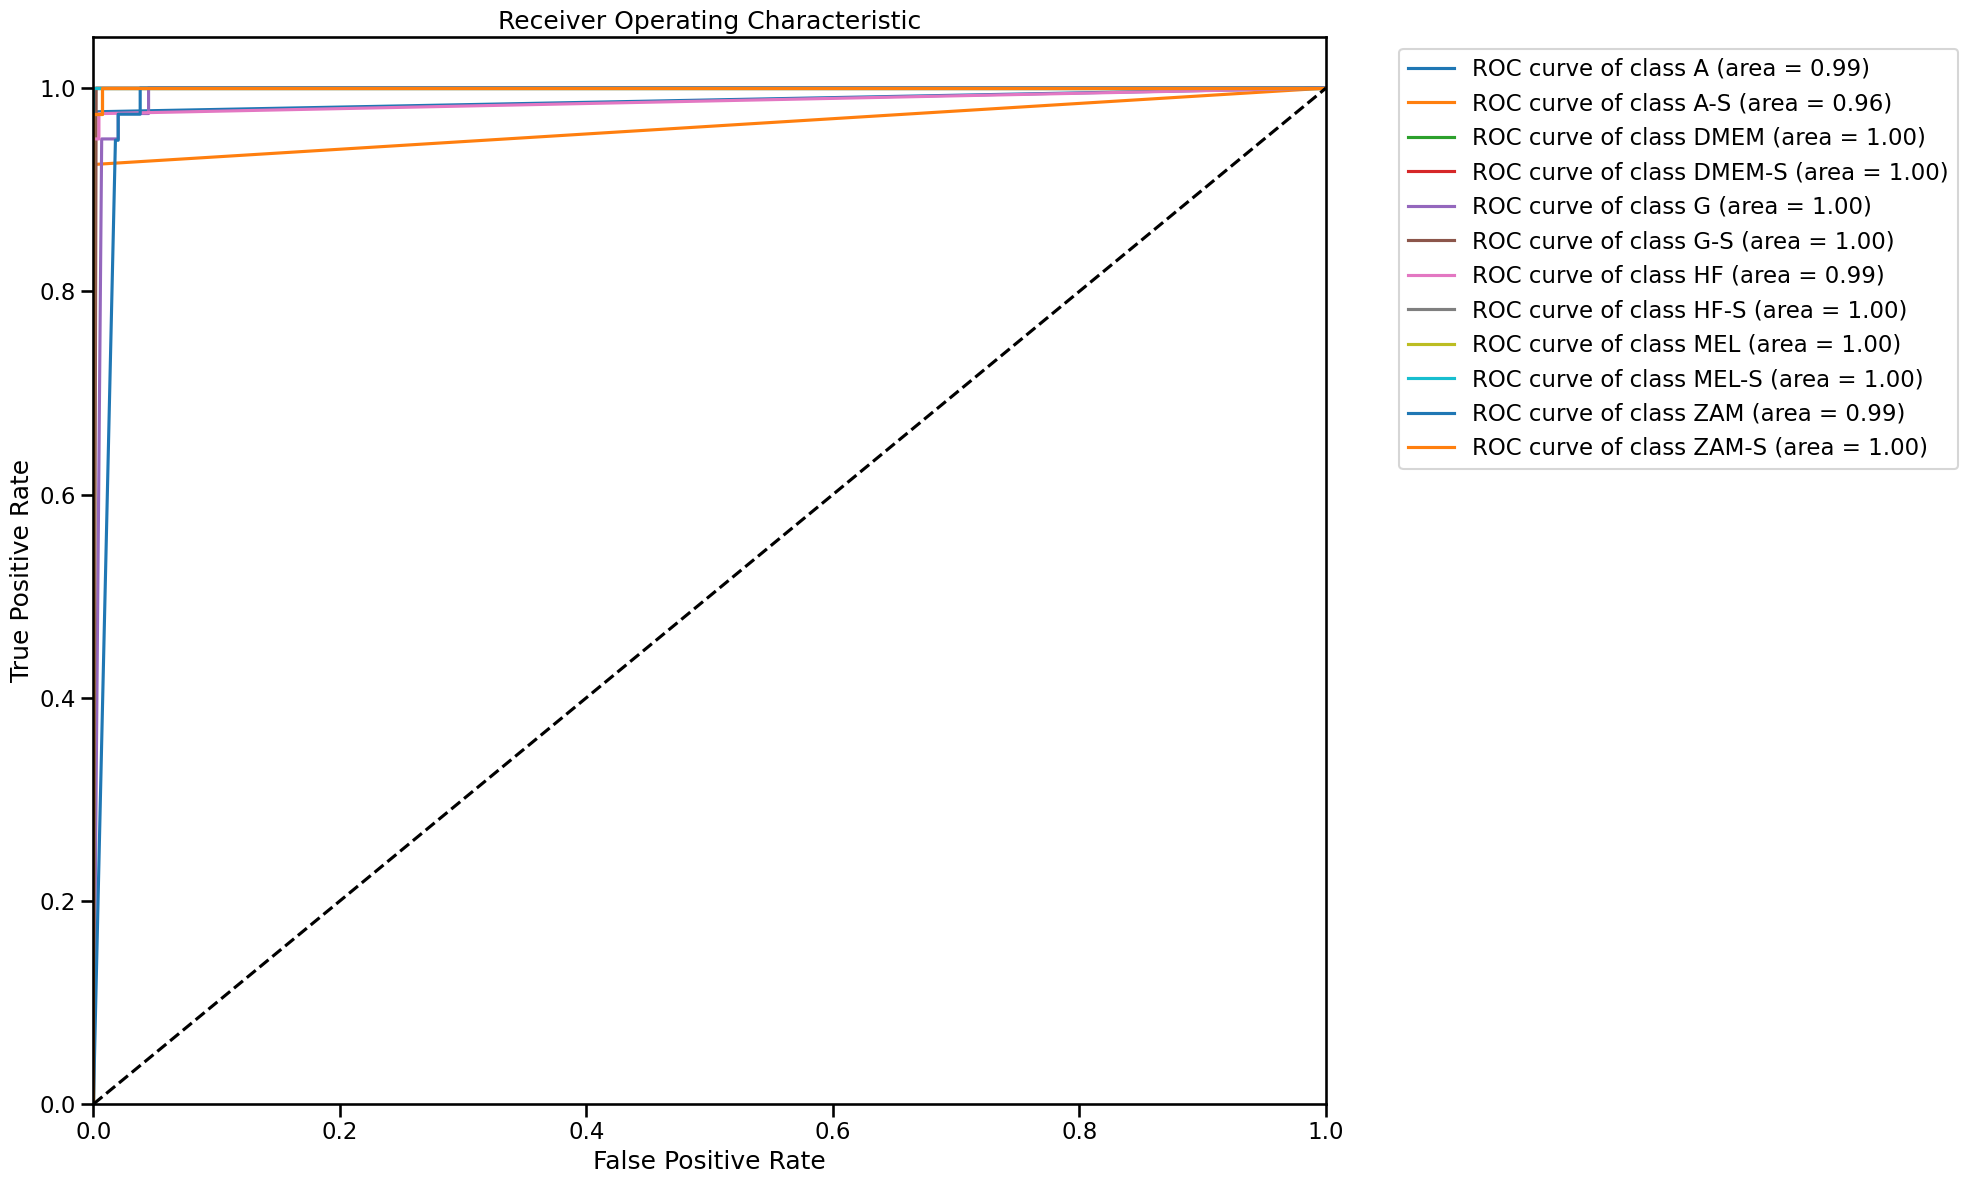

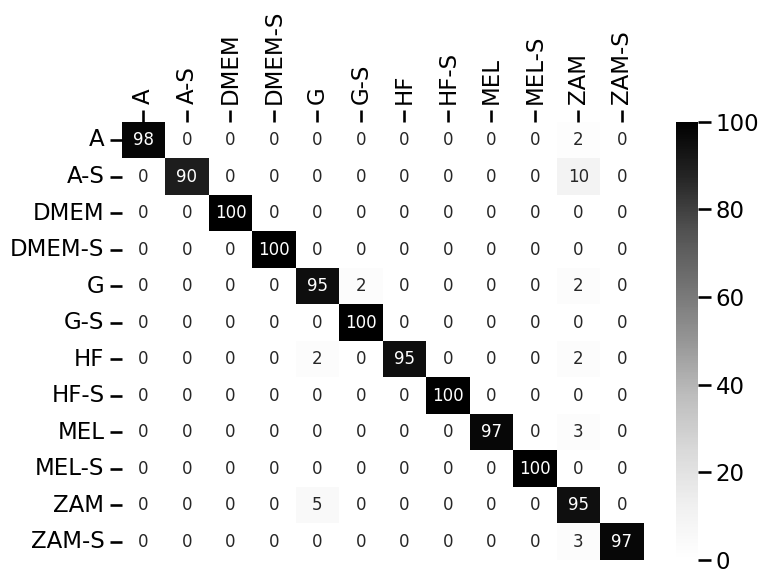

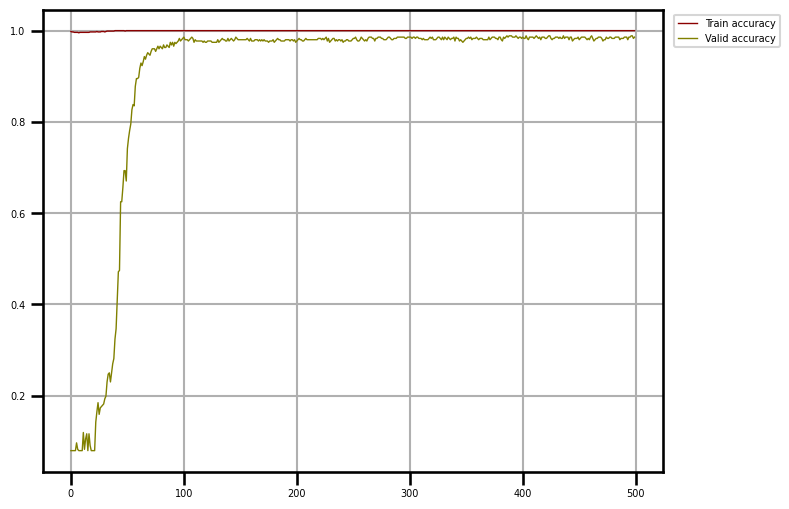

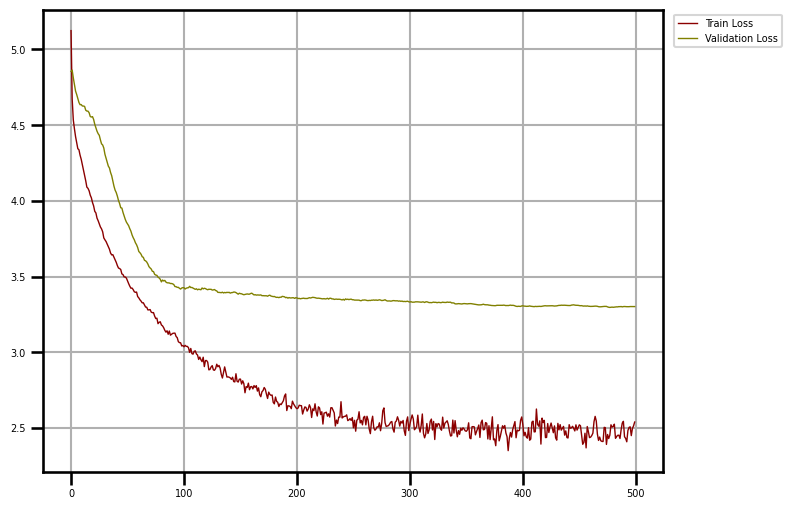

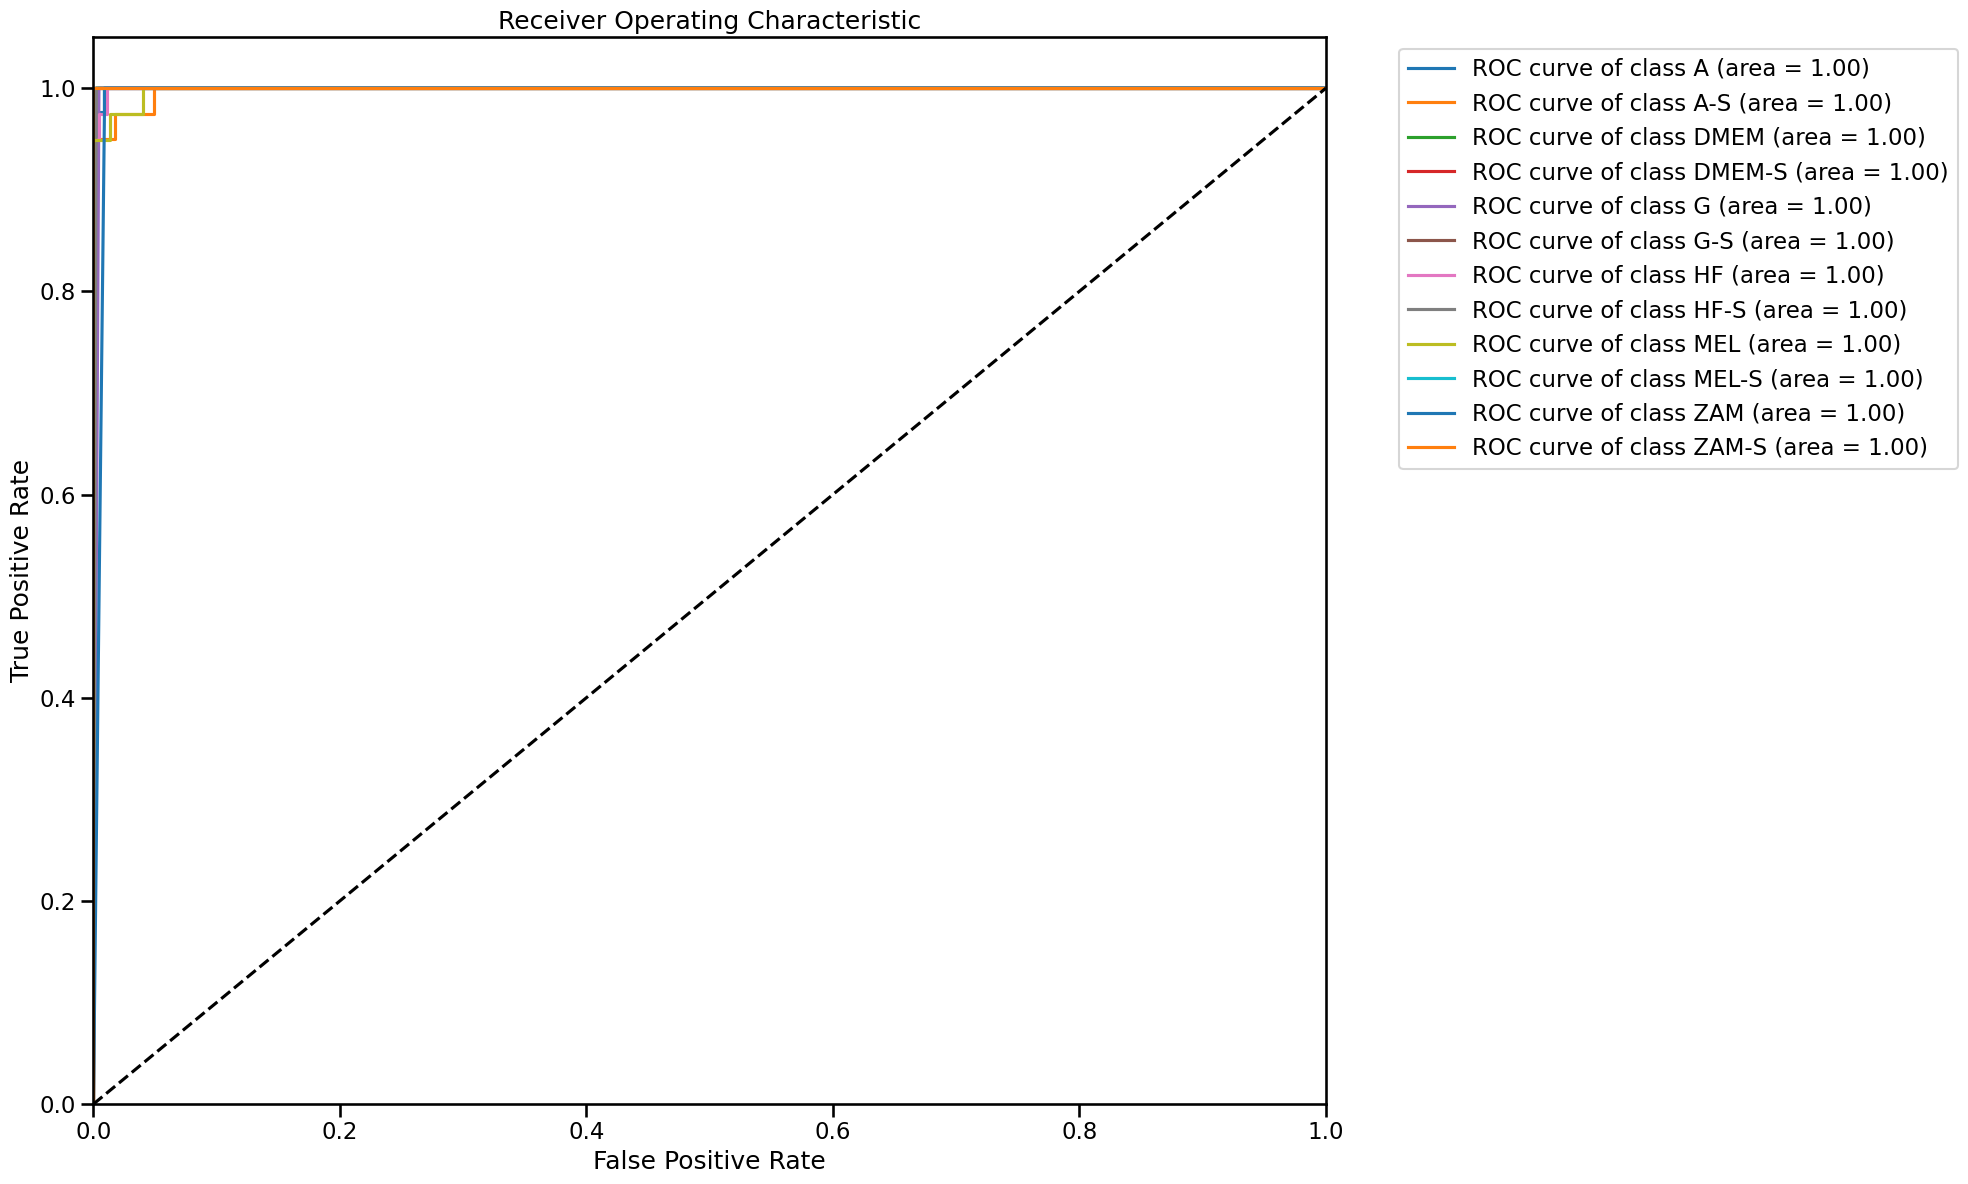

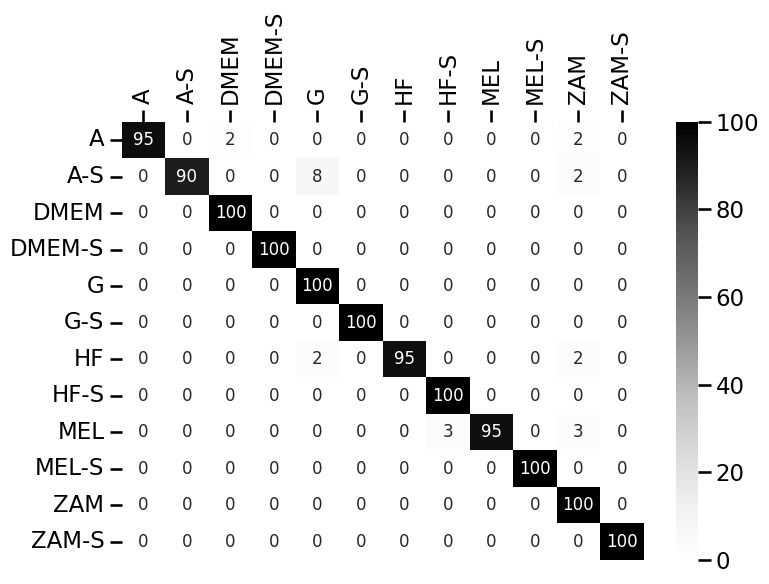

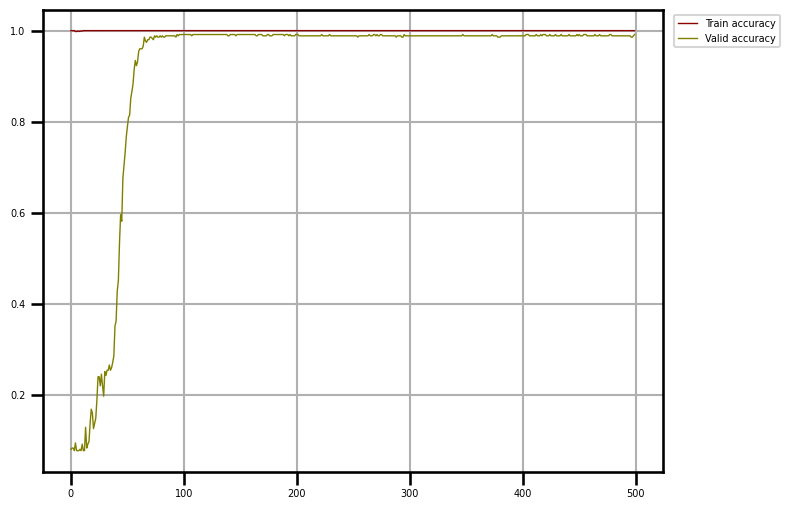

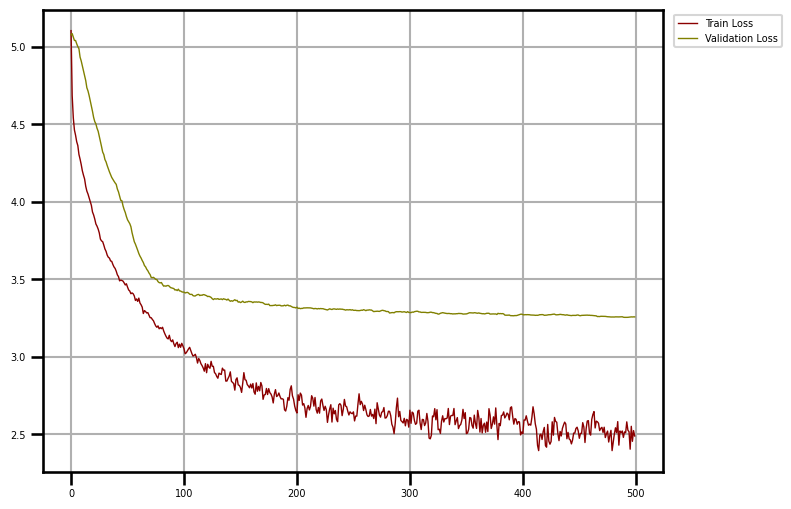

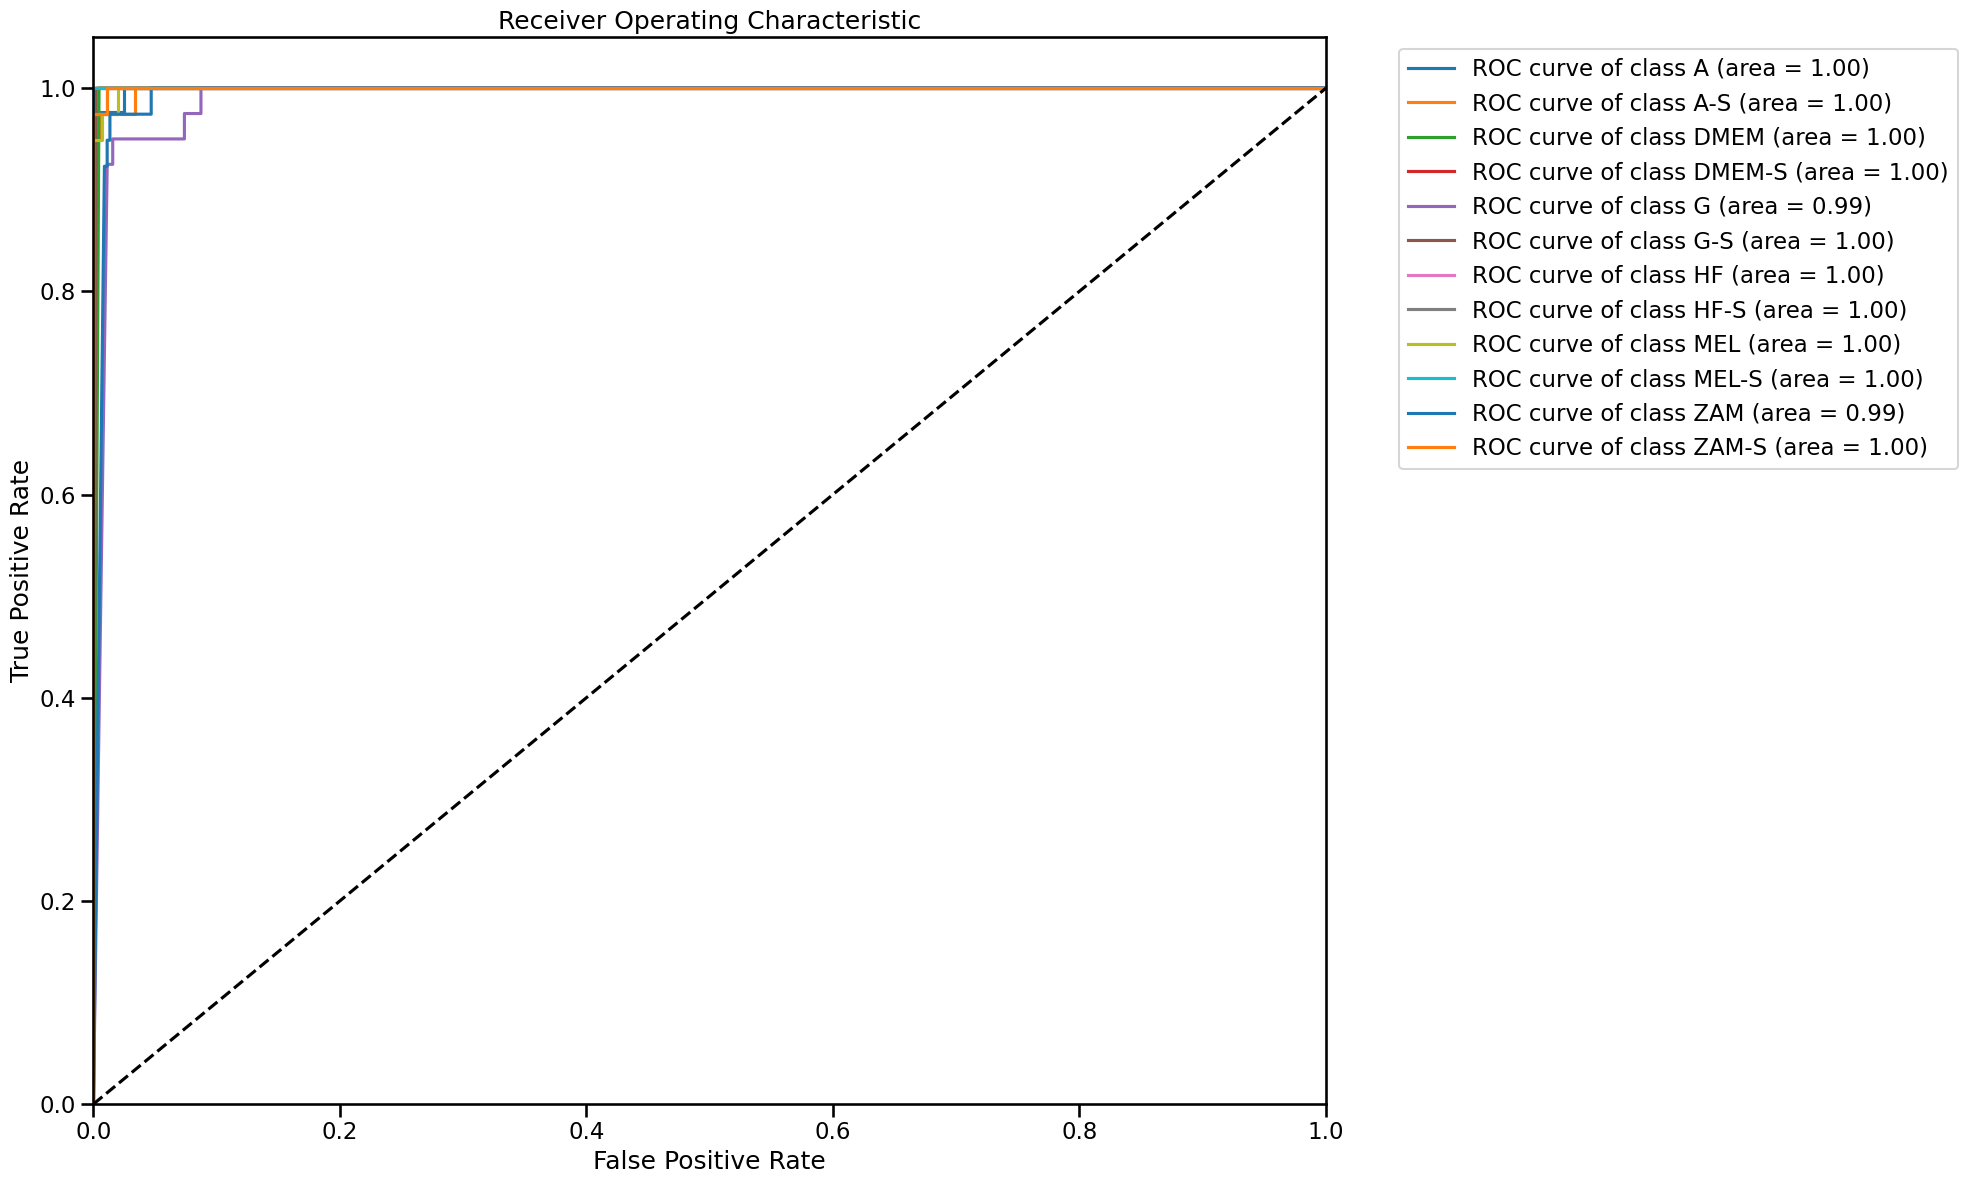

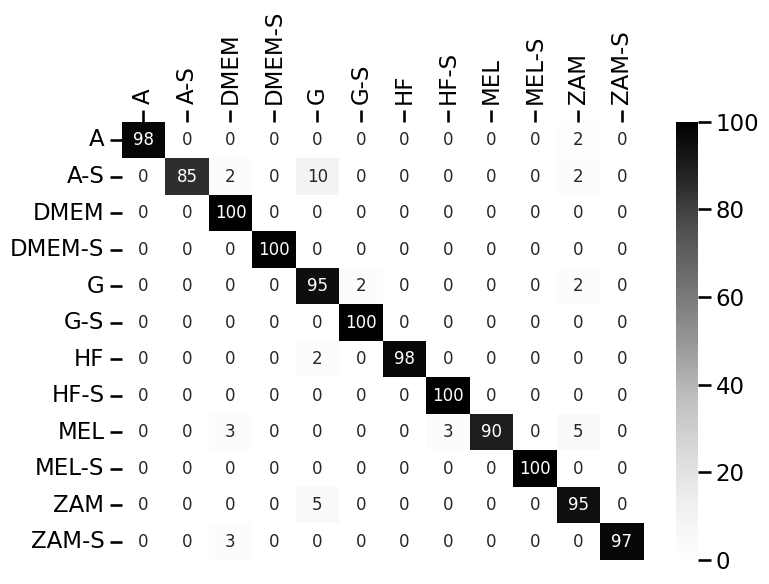

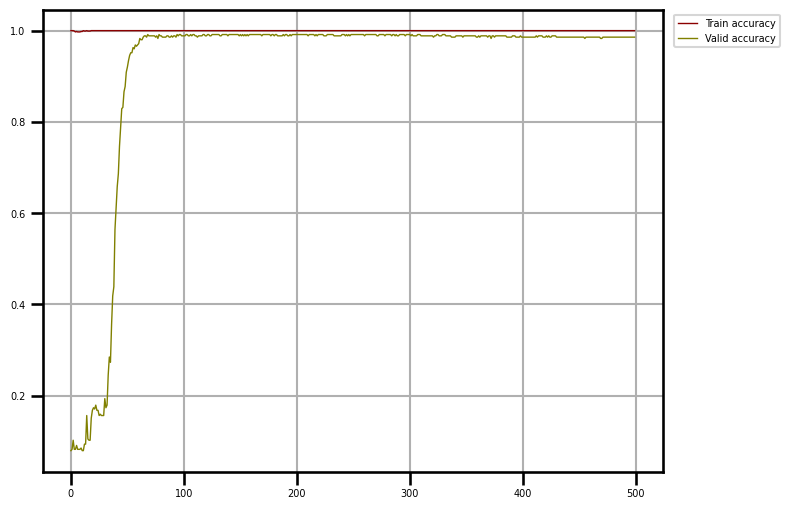

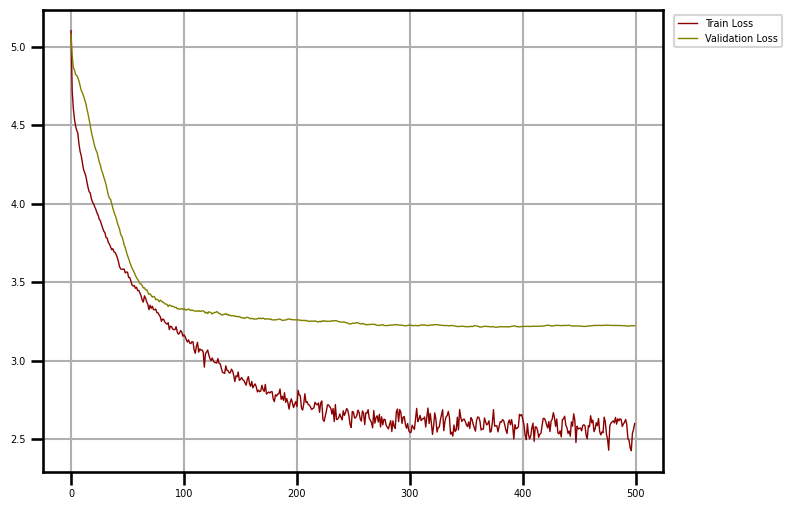

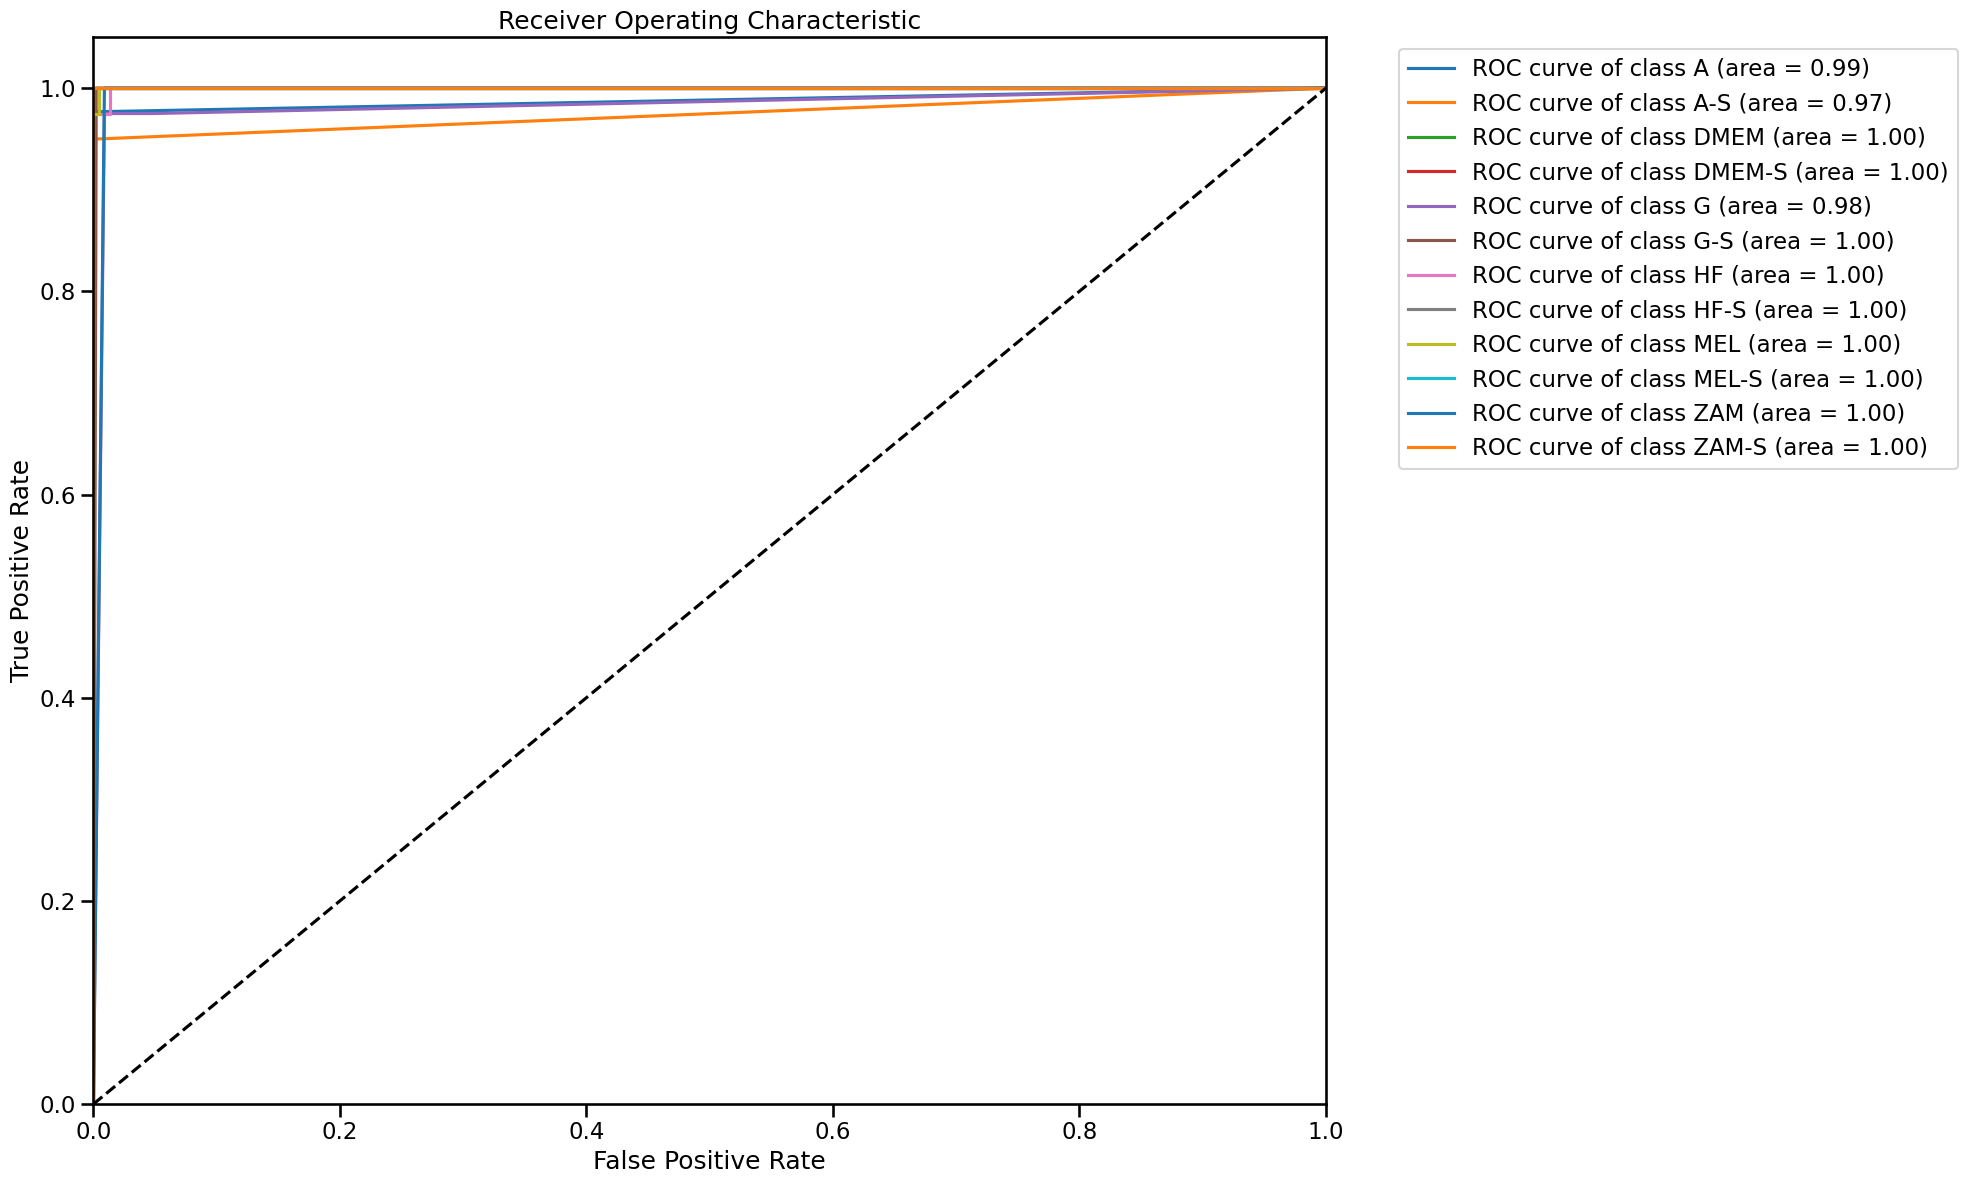

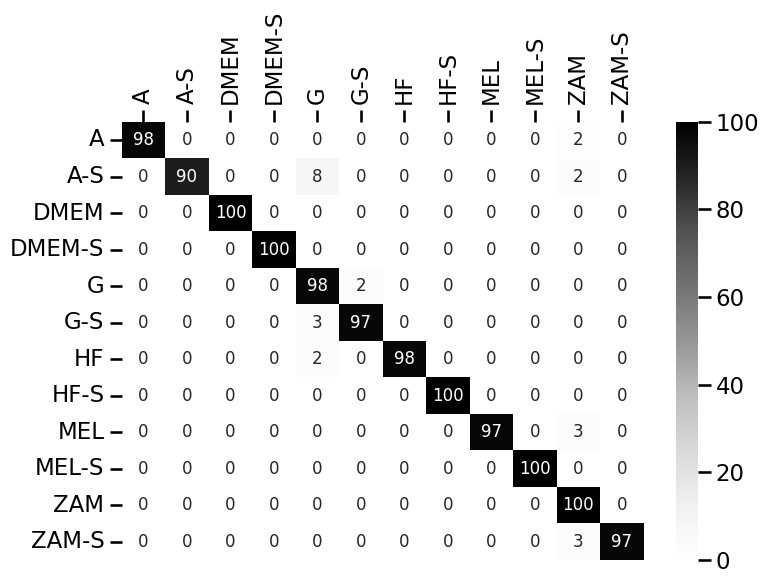

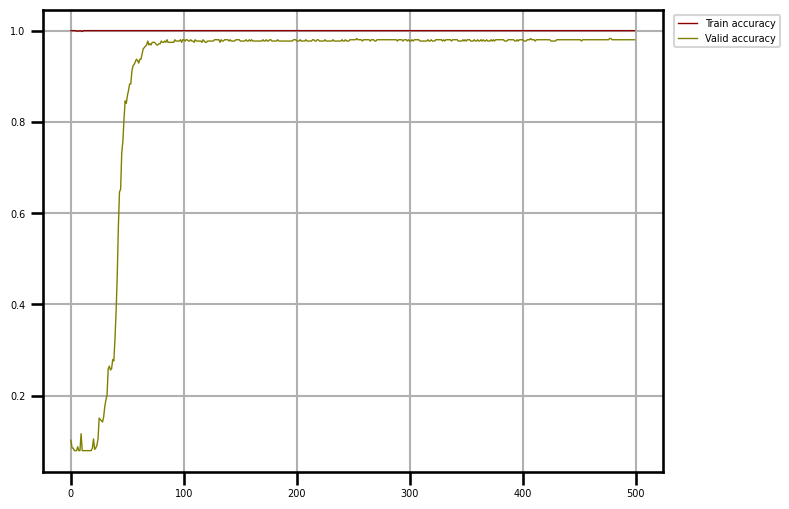

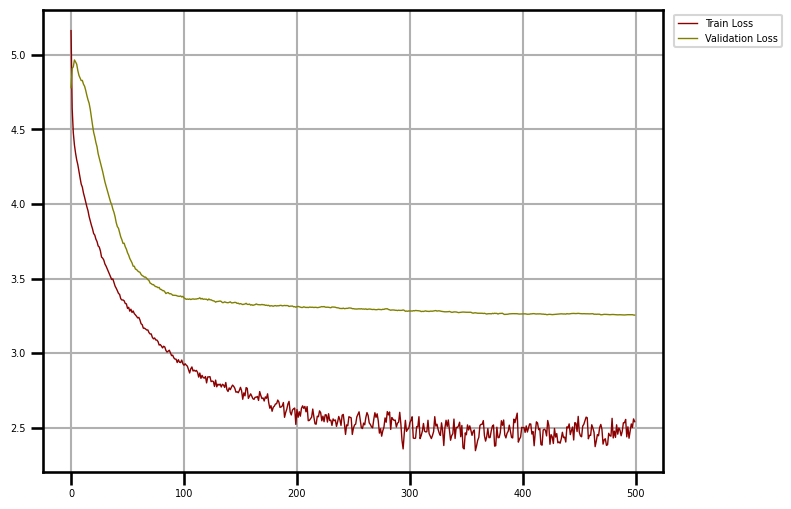

In [6]:
from sklearn.model_selection import StratifiedKFold
from datasets_spectrum import spectral_dataloader

kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
fold_index = 1

for train_idx, valid_idx in kfold.split(train_data, train_label):

    print("fold:", fold_index)
    x_train, y_train = train_data[train_idx], train_label[train_idx]
    x_valid, y_valid = train_data[valid_idx], train_label[valid_idx]
    
    print("train size: ", len(x_train))
    print("validation size: ", len(x_valid))
    print("test size: ", len(test_data))

    dl_tr = spectral_dataloader(
        x_train, y_train, idxs=None, batch_size=batch_size, shuffle=True
    )
    dl_val = spectral_dataloader(
        x_valid, y_valid, idxs=None, batch_size=batch_size, shuffle=False
    )
    dl_test = spectral_dataloader(test_data, test_labels, batch_size=batch_size, shuffle=False)

    values, counts = np.unique(np.asarray(test_labels), return_counts=True)

    dataloaders = {"train": dl_tr, "val": dl_val, "test": dl_test}
    model = Variant_LeNet_without_linear(in_channels=1)

    model_path = f"best_melanoma_variant_lenet_model_{fold_index}.pt"
    solver = Solver(
        dataloaders, model, model_path, "cuda", n_classes
    )
    
    train_accuracy, val_accuracy, useful_stuff = solver.train(500)
    C, y_true, y_pred, test_accuracy, y_pred_prob = solver.test()
    train_avg_accuracy.append(train_accuracy)
    val_avg_accuracy.append(val_accuracy)
    avg_accuracy.append(np.round(test_accuracy,4))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(np.unique(y_true).shape[0]):
        fpr[i], tpr[i], _ = roc_curve(test_labels == i, y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    values = [
        v
        for v in roc_auc.values()
        if isinstance(v, (int, float)) and not math.isnan(v)
    ]
    if values:
        auc_score = sum(values) / len(values)
    avg_roc.append(auc_score)

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5, 6 ,7 ,8 ,9 ,10, 11])
    sns.set_context("talk", rc={"font": "Helvetica", "font.size": 12})
    label = ['A', 'A-S', 'DMEM', 'DMEM-S', 'G', 'G-S', 'HF', 'HF-S', 'MEL', 'MEL-S', 'ZAM', 'ZAM-S']
    cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]

    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred, average="micro", zero_division=0)
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    f1 = f1_score(y_true, y_pred, average="micro", zero_division=0)

    df = pd.DataFrame(
        {
            "Accuracy": [np.round(accuracy_score(y_true, y_pred), 4)],
            "Recall": [
                recall_score(y_true, y_pred, average=None, zero_division=0).round(4)
            ],
            "Specificity": [specificity_score(y_true, y_pred, average=None).round(4)],
            "Precision": [
                precision_score(y_true, y_pred, average=None, zero_division=0).round(4)
            ],
            "F1 Score": [
                f1_score(y_true, y_pred, average=None, zero_division=0).round(4)
            ],
        }
    )
    print(df.transpose())

    plot_melanoma_ROC_curve("variant_lenet", y_true, test_labels, y_pred_prob, fold_index=fold_index)
    plot_melanoma_heatmap("variant_lenet", cm, fold_index=fold_index)
    plot_metrics(training_results=useful_stuff, fold_index=fold_index, fold_name="variant_lenet")
    plot_loss_metrics(training_results=useful_stuff, fold_index=fold_index, fold_name="variant_lenet")

    fold_index += 1

In [8]:
print(avg_accuracy)
print("train mean:", round(np.mean(train_avg_accuracy),4))
print("train std:", round(np.std(train_avg_accuracy),4))

print("val mean:", round(np.mean(val_avg_accuracy),4))
print("val std:", round(np.std(val_avg_accuracy),4))

print("test mean:", round(np.mean(avg_accuracy),4))
print("test std:", round(np.std(avg_accuracy),4))

print("auc mean:", round(np.mean(avg_roc),4))
print("auc std:", round(np.std(avg_roc),4))

[0.9733, 0.9795, 0.9651, 0.9795]
train mean: 1.0
train std: 0.0
val mean: 0.9886
val std: 0.0035
test mean: 0.9744
test std: 0.0059
auc mean: 0.9964
auc std: 0.0022
